# ETL Rest of the time series

Suma del consumo de laas dos enfriadoras (kW). Sabemos que el consumo se encuentra en la fila "basement" del dataframe original y que la columna Power13 es el consumo de la enfriadora 1 (serie temporal guardada en Hash table) y Power 14 lo mismo para enfriadora 2. Mediciones en kW.

In [2]:
## Imports
from pyspark.sql import SparkSession
from pyspark import SparkContext
import os
import copy
import time
import statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Spark dependencies
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark import StorageLevel, SparkConf
from pyspark.ml.feature import StandardScaler, VectorAssembler, PCA
from pyspark.mllib.linalg import SparseVector, DenseVector, VectorUDT
from pyspark.ml.classification import LogisticRegression

from pyspark.sql import functions as F
from pyspark.sql.window import Window
from datetime import datetime, timedelta
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import col, expr, udf, sequence

# Other configs
pd.options.display.float_format = "{:.2f}".format

# Useful directory variables
src_path = os.getcwd()
root_path = os.path.dirname(src_path)
data_path = root_path + "/datasets"
visualization_path = root_path + "/data_visualization"

# Start counting time
start_t = time.time()
# Reading the original file
df = spark.read.parquet(
    "output_final.parquet"
)  # Functional programming. Reading the raw data file with the Structured API
# df.printSchema()
df.createOrReplaceTempView("df")

# Generating a dataFrame with the times (every 30 minutes from start_timestamp to end_timestamp)
dates = pd.date_range(
    start=datetime(2018, 1, 1, 0, 0, 0),
    end=datetime(2021, 6, 30, 0, 0, 0),
    freq="30min",
)
datetimes = [date.to_pydatetime() for date in dates]
time_df = (
    spark.createDataFrame(datetimes, TimestampType())
    .withColumnRenamed("value", "time")
    .sort(F.asc("time"))
)

# Obtaning each consumption node in a list
node_list = (
    spark.sql("SELECT node from df").rdd.flatMap(lambda x: x).collect()
)  # Getting the list with all the node names


In [2]:
df.printSchema()

root
 |-- node: string (nullable = true)
 |-- start_time: timestamp (nullable = true)
 |-- end_time: timestamp (nullable = true)
 |-- power: map (nullable = true)
 |    |-- key: timestamp
 |    |-- value: float (valueContainsNull = true)
 |-- Power13: map (nullable = true)
 |    |-- key: timestamp
 |    |-- value: float (valueContainsNull = true)
 |-- Power14: map (nullable = true)
 |    |-- key: timestamp
 |    |-- value: float (valueContainsNull = true)
 |-- in: map (nullable = true)
 |    |-- key: timestamp
 |    |-- value: float (valueContainsNull = true)
 |-- out: map (nullable = true)
 |    |-- key: timestamp
 |    |-- value: float (valueContainsNull = true)
 |-- evaporator: map (nullable = true)
 |    |-- key: timestamp
 |    |-- value: float (valueContainsNull = true)
 |-- ambient: map (nullable = true)
 |    |-- key: timestamp
 |    |-- value: float (valueContainsNull = true)
 |-- Compressor1: map (nullable = true)
 |    |-- key: timestamp
 |    |-- value: float (valueContains

In [4]:
node_list[-3:]

['1', '2', 'basement']

## Cosumo en kW de las enfriadoras 1 y 3.

Se calcula la media en ventanas temporales de 30 minutos tal y como se ha realizado con los nodos del cluster. 

In [19]:
sql_query_chiller_1_consumption = """
                SELECT 
                    EXPLODE(Power13) as (time, chiller_1_power_consumption) 
                FROM df
                WHERE 
                    node LIKE "basement"
            """
chiller_1_consumption = spark.sql(sql_query_chiller_1_consumption)
chiller_1_consumption = chiller_1_consumption.withColumn(
    "time", F.to_timestamp(chiller_1_consumption.time, "yyyy-MM-dd HH:MM:SS")
)
chiller_1_consumption = chiller_1_consumption.groupBy(
    "time", F.window("time", "30 minutes")
).agg(
    avg(
        "chiller_1_power_consumption").alias("chiller_1_power_consumption"),
    )
chiller_1_consumption = chiller_1_consumption.select(
    "time", "window.*", "chiller_1_power_consumption"
).sort(F.asc("time"))

chiller_1_consumption = chiller_1_consumption.select(
    col("end").alias("time"), col("chiller_1_power_consumption")
)
chiller_1_consumption = chiller_1_consumption.groupBy("time").agg(
    avg("chiller_1_power_consumption").alias("chiller_1_average_power_consumption"))

chiller_1_consumption = chiller_1_consumption.select(
    "time", "chiller_1_average_power_consumption"
).sort(F.asc("time"))
chiller_1_consumption = time_df.join(chiller_1_consumption, ["time"], how="left").sort(
    F.asc("time")
)
chiller_1_consumption = chiller_1_consumption.fillna(
    0, subset=["chiller_1_average_power_consumption"]
)
chiller_1_consumption.cache()
chiller_1_consumption.show(5)
chiller_1_consumption.write.parquet("chiller_1_consumption_total_average_30min_kW")

+-------------------+-----------------------------------+
|               time|chiller_1_average_power_consumption|
+-------------------+-----------------------------------+
|2018-01-01 00:00:00|                                0.0|
|2018-01-01 00:30:00|                 37.522221671210396|
|2018-01-01 01:00:00|                  24.84444448682997|
|2018-01-01 01:30:00|                   37.6555553012424|
|2018-01-01 02:00:00|                  45.44999933242798|
+-------------------+-----------------------------------+
only showing top 5 rows



In [3]:
#De modo similar para la segunda enfriadora
sql_query_chiller_2_consumption = """
                SELECT 
                    EXPLODE(Power14) as (time, chiller_2_power_consumption) 
                FROM df
                WHERE 
                    node LIKE "basement"
            """
chiller_2_consumption = spark.sql(sql_query_chiller_2_consumption)
chiller_2_consumption = chiller_2_consumption.withColumn(
    "time", F.to_timestamp(chiller_2_consumption.time, "yyyy-MM-dd HH:MM:SS")
)
chiller_2_consumption = chiller_2_consumption.groupBy(
    "time", F.window("time", "30 minutes")
).agg(
    avg(
        "chiller_2_power_consumption").alias("chiller_2_power_consumption"),
    )
chiller_2_consumption = chiller_2_consumption.select(
    "time", "window.*", "chiller_2_power_consumption"
).sort(F.asc("time"))

chiller_2_consumption = chiller_2_consumption.select(
    col("end").alias("time"), col("chiller_2_power_consumption")
)
chiller_2_consumption = chiller_2_consumption.groupBy("time").agg(
    avg("chiller_2_power_consumption").alias("chiller_2_average_power_consumption"))

chiller_2_consumption = chiller_2_consumption.select(
    "time", "chiller_2_average_power_consumption"
).sort(F.asc("time"))
chiller_2_consumption = time_df.join(chiller_2_consumption, ["time"], how="left").sort(
    F.asc("time")
)
chiller_2_consumption = chiller_2_consumption.fillna(
    0, subset=["chiller_2_average_power_consumption"]
)
chiller_2_consumption.cache()
chiller_2_consumption.show(5)
chiller_2_consumption.write.parquet("chiller_2_consumption_total_average_30min_kW")

+-------------------+-----------------------------------+
|               time|chiller_2_average_power_consumption|
+-------------------+-----------------------------------+
|2018-01-01 00:00:00|                                0.0|
|2018-01-01 00:30:00|                                0.0|
|2018-01-01 01:00:00|                                0.0|
|2018-01-01 01:30:00|                                0.0|
|2018-01-01 02:00:00|                                0.0|
+-------------------+-----------------------------------+
only showing top 5 rows



Al terminar, realizamos desde terminal hdfs dfs -get para pasar los .parquet generados del almacenamiento en el sistema de ficheros HDFS distribuido del cluster al sistema local del nodo de entrada (ext4). Lo realizaremos en /datasets/02_intermediate de acuerdo a la data engineering convention de Quantum Black (https://towardsdatascience.com/the-importance-of-layered-thinking-in-data-engineering-a09f685edc71   y    https://docs.kedro.org/en/stable/faq/faq.html)

In [8]:
chiller_1_pandas = pd.read_parquet(
    data_path + "/02_intermediate/" + "chiller_1_consumption_total_average_30min_kW"
)
chiller_2_pandas = pd.read_parquet(
    data_path + "/02_intermediate/" + "chiller_2_consumption_total_average_30min_kW"
)
chiller_1and2_consumption_pandas = pd.merge(
    chiller_1_pandas,
    chiller_2_pandas,
    on="time",
)
chiller_1and2_consumption_pandas["total_average_power_consumption_kW"] = (
    chiller_1and2_consumption_pandas.chiller_1_average_power_consumption
    + chiller_1and2_consumption_pandas.chiller_2_average_power_consumption
)
chiller_1and2_consumption_pandas.drop(
    ["chiller_1_average_power_consumption", "chiller_2_average_power_consumption"],
    axis=1,
    inplace=True,
)
chiller_1and2_consumption_pandas.to_parquet(
    data_path + "/03_primary/" + "chiller_1and2_consumption_total_average_30_min_kW"
)  # Snappy by default. Optimal for write once read many


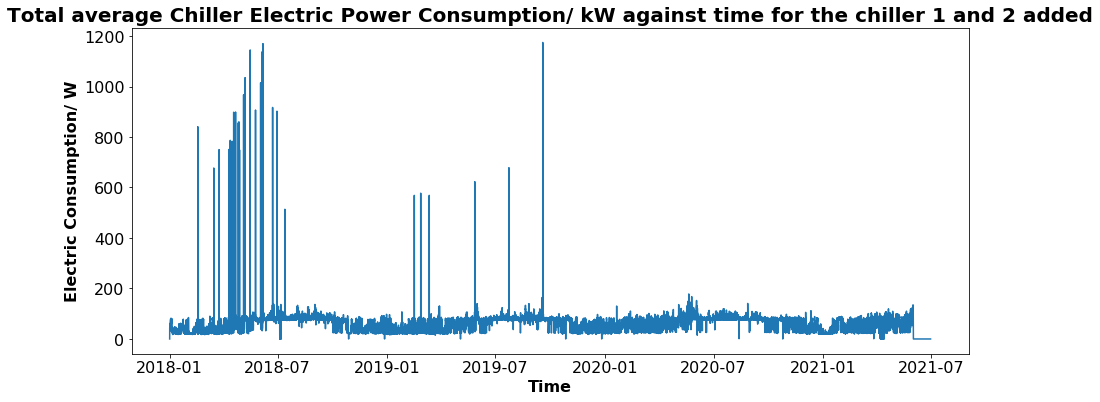

In [9]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(chiller_1and2_consumption_pandas['time'], chiller_1and2_consumption_pandas['total_average_power_consumption_kW'] )

ax.set_title('Total average Chiller Electric Power Consumption/ kW against time for the chiller 1 and 2 added', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Time', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Electric Consumption/ W', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

# Presion maxima 4 compresores (2 por enfriadora) en Pascales
Nuevamente agrupacion en ventanas de 30 minutos, pero en este caso en lugar del valor medio tomamos como metrica de agrupacion la lectura maxima en esa ventana. Sacamos cada una de las 4 series temporales y luego las juntamos en pandas.